<h1><center> HACKDAY - COMUNIDADE DS' COMPETITION</center></h1>

<h3><center> This approach scored 0.89529 in another <a href="https://www.kaggle.com/competitions/incluso-financeira-na-africa-late-submission/overview" target="_blank">competition's</a> test dataset. Main change was labeling "household_size" instead of using RobustScaler or applying np.log.</center></h2>



# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from IPython.core.display  import HTML
from IPython.display       import Image

from itertools import combinations

from lightgbm                import LGBMClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import LogisticRegressionCV
from sklearn.metrics         import confusion_matrix


from xgboost                 import XGBClassifier
from sklearn.svm             import SVC
from catboost                import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics         import accuracy_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import roc_auc_score

from scikitplot              import metrics         as mt

from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 16

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    sns.set()
jupyter_settings()

## 0.2. Loading Data

In [3]:
# Load the datasets
train = pd.read_csv('/kaggle/input/inclusao-financeira-na-africa/train.csv')
test = pd.read_csv('/kaggle/input/inclusao-financeira-na-africa/test.csv')

In [4]:
train.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,2016,uniqueid_4858,Rural,Yes,6,45,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,2017,uniqueid_3015,Urban,No,4,33,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,2016,uniqueid_103,Rural,Yes,7,43,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,2016,uniqueid_4582,Rural,No,6,35,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,2017,uniqueid_2854,Urban,Yes,2,30,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


In [5]:
display(train.shape)
display(test.shape)

(11762, 14)

(11762, 13)

In [6]:
print(f"Number of overlapping ID's between Train and Test set: {train['uid'].isin(test['uid']).sum()}")

Number of overlapping ID's between Train and Test set: 0


# 1.0 DATA DESCRIPTION

In [7]:
df1 = train.copy()

## 1.1 Recognizing Dataset

In [8]:
df1.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'uid', 'bank_account'],
      dtype='object')

- country - Pais de Origem.
- year - Ano da Inclusão.
- uniqueid - Id do Usuário.
- bank_account - Possui ou Não a Conta no Banco.
- location_type - Tipo de Localidade (Rural...)
- cellphone_access - Possui ou Não Celular.
- **household_size - Número de membros familiares.**
- age_of_respondent - Idade do Usuário.
- gender_of_respondent - Gênero do Usuário.
- relationship_with_head - Status com o Dono da Conta.
- marital_status - Situação Civil.
- education_level - Nível de Educação.
- job_type - Tipo de Trabalho.

In [9]:
df1.dtypes

country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
uid                       object
bank_account              object
dtype: object

## 1.2 Checking Missing Values

In [10]:
df1.isna().sum().sort_values(ascending=False)

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
uid                       0
bank_account              0
dtype: int64

## 1.3 Checking Unique Quantities

In [11]:
u_ids = ['uniqueid', 'uid']
for col_name in df1.columns:
    if (df1[col_name].dtypes == 'object') and col_name not in u_ids:
        unique_cat = len(df1[col_name].unique())
        print(f"Feature '{col_name}' has {unique_cat} unique categories.")

Feature 'country' has 4 unique categories.
Feature 'location_type' has 2 unique categories.
Feature 'cellphone_access' has 2 unique categories.
Feature 'gender_of_respondent' has 2 unique categories.
Feature 'relationship_with_head' has 6 unique categories.
Feature 'marital_status' has 5 unique categories.
Feature 'education_level' has 6 unique categories.
Feature 'job_type' has 10 unique categories.
Feature 'bank_account' has 2 unique categories.


**There is no feature with a large number of categories (<20) and we will apply OneHotEncoding on all our variables.**


## 1.4 Checking Balance

In [12]:
df1[['bank_account', 'uniqueid']].groupby('bank_account').agg({'uniqueid':'count'}).sort_values('bank_account', ascending=False)

balance = pd.DataFrame(data=df1[['bank_account', 'uniqueid']].groupby('bank_account').agg({'uniqueid':'count'}).sort_values('bank_account', ascending=False), columns=['uniqueid'])
balance['Percent'] = balance['uniqueid'].apply(lambda x: '{:.2f}%'.format(float(x)/df1.shape[0]*100))
balance = balance[balance['uniqueid'] > 0]
balance

,uniqueid,Percent
bank_account,,
Yes,1685,14.33%
No,10077,85.67%


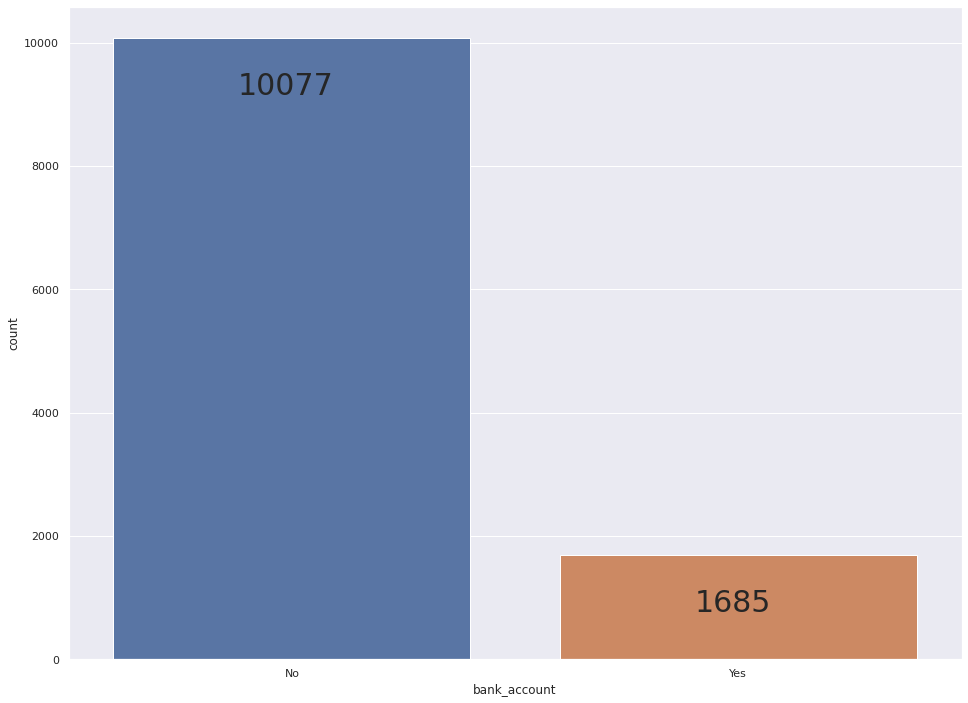

In [13]:
# visualize the target variable
g = sns.countplot(x=df1['bank_account'])
g.set_xticklabels(['No','Yes'])
for p in g.patches:
    g.annotate('\n{:.0f}'.format(p.get_height()), (p.get_x()+0.387, p.get_height()), ha='center', va='top', size=30)
plt.show()


## 1.5 Checking Correlation

In [14]:
cat_attributes = df1.select_dtypes(exclude='int64')
cat_attributes.head()

,country,uniqueid,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid,bank_account
0,Rwanda,uniqueid_4858,Rural,Yes,Male,Head of Household,Divorced/Seperated,Primary education,Farming and Fishing,Rwanda_uniqueid_4858,No
1,Tanzania,uniqueid_3015,Urban,No,Female,Head of Household,Single/Never Married,Primary education,Self employed,Tanzania_uniqueid_3015,No
2,Rwanda,uniqueid_103,Rural,Yes,Male,Head of Household,Married/Living together,Secondary education,Farming and Fishing,Rwanda_uniqueid_103,No
3,Rwanda,uniqueid_4582,Rural,No,Female,Head of Household,Married/Living together,Primary education,Farming and Fishing,Rwanda_uniqueid_4582,No
4,Tanzania,uniqueid_2854,Urban,Yes,Male,Head of Household,Single/Never Married,Primary education,Informally employed,Tanzania_uniqueid_2854,No


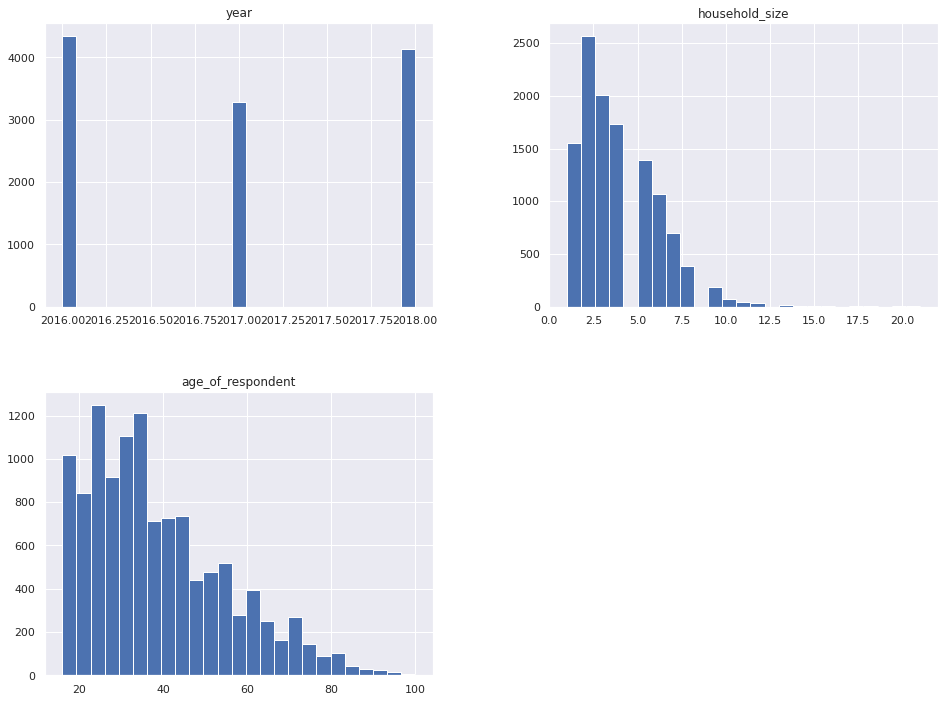

In [15]:
num_attributes = df1.select_dtypes(include='int64')
num_attributes.hist(bins=25);


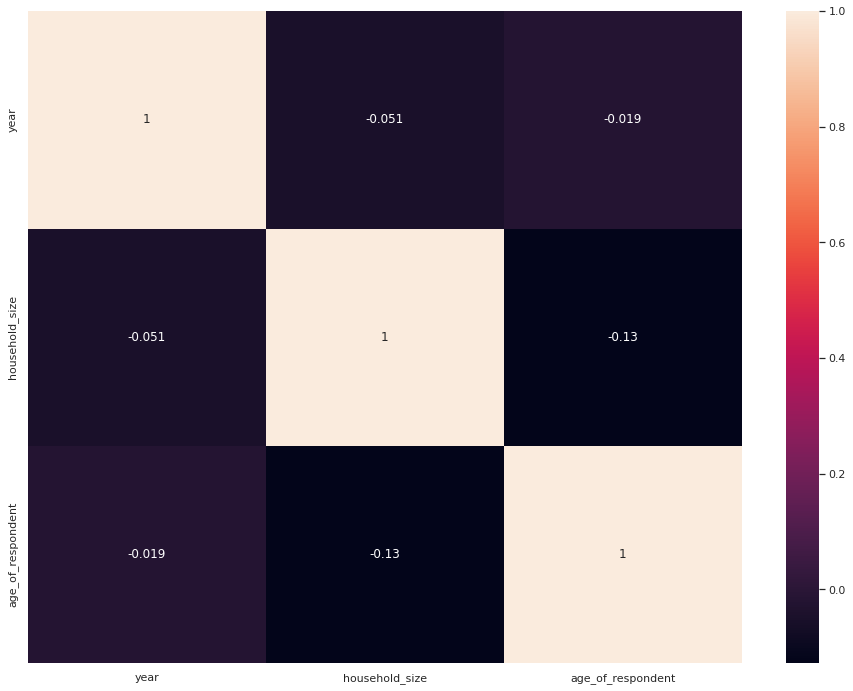

In [16]:
sns.heatmap(df1.corr(), annot=True);

# 2.0 FEATURE ENGINEERING

In [17]:
df2 = df1.copy()
aux1 = df1.copy()
aux2 = test.copy()

## 2.1 Handling Categories

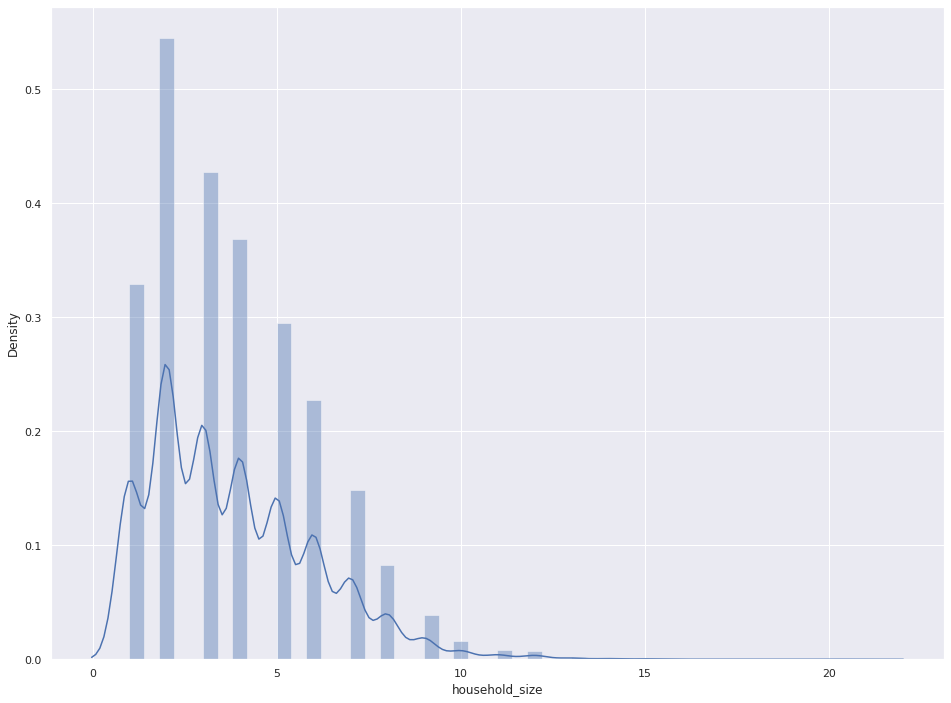

In [19]:
sns.distplot(aux1.household_size);

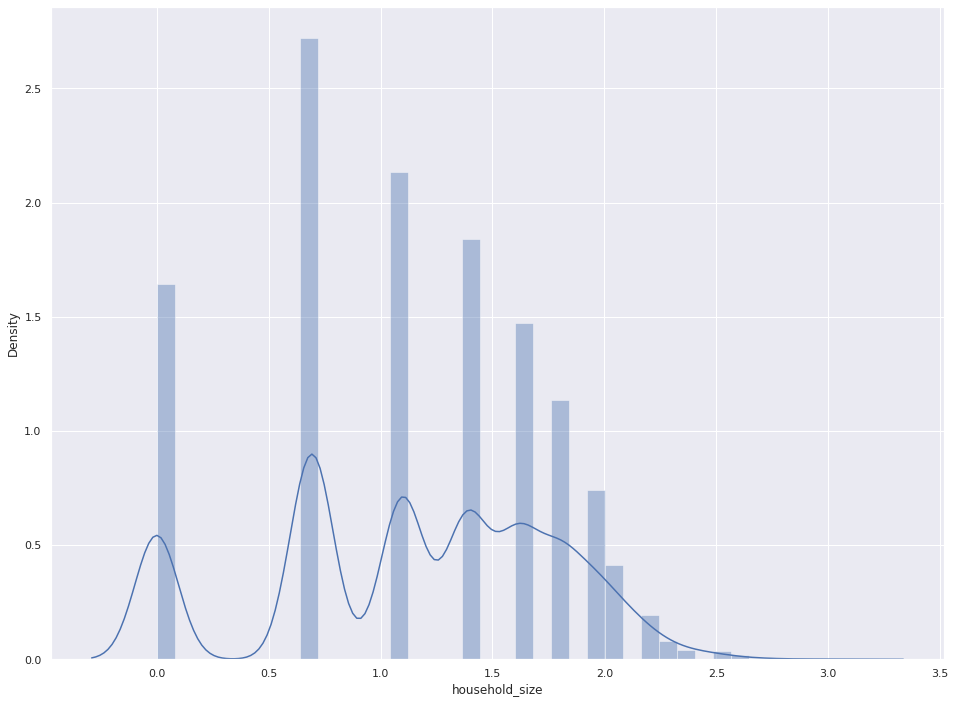

In [20]:
sns.distplot(np.log(aux1.household_size));

## 2.2 Robust Scaler and Labeling Ages

Updated after seeing Private Scores: using Label to "household_size" as well performs better.

In [22]:
features = aux1.drop(['year', 'uniqueid', 'uid', 'bank_account'], axis=1)

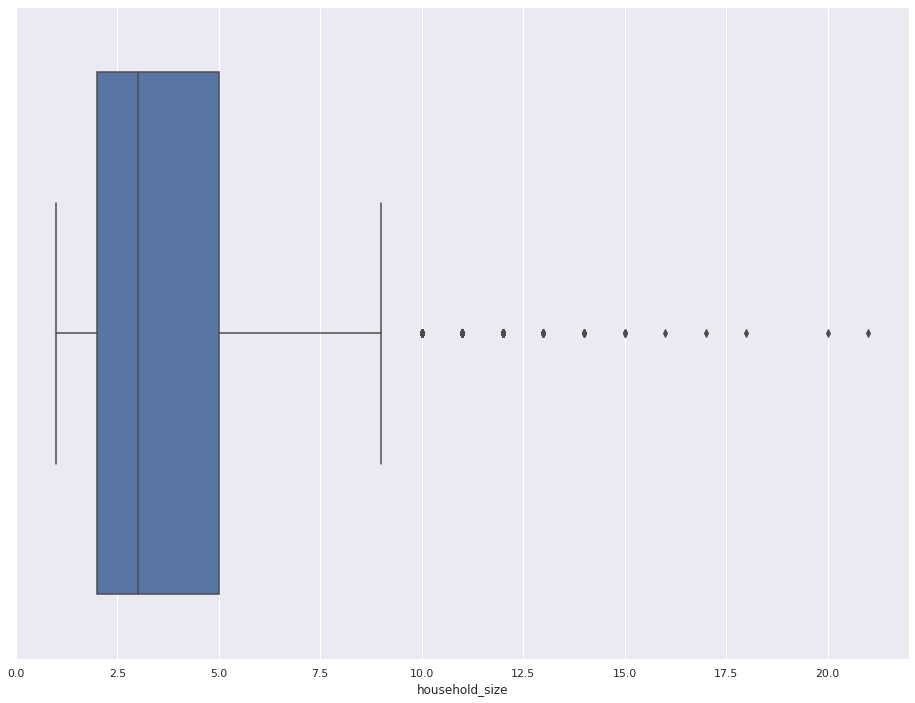

In [23]:
# features.household_size.plot(kind='box')
sns.boxplot(data=features, x=features['household_size']);

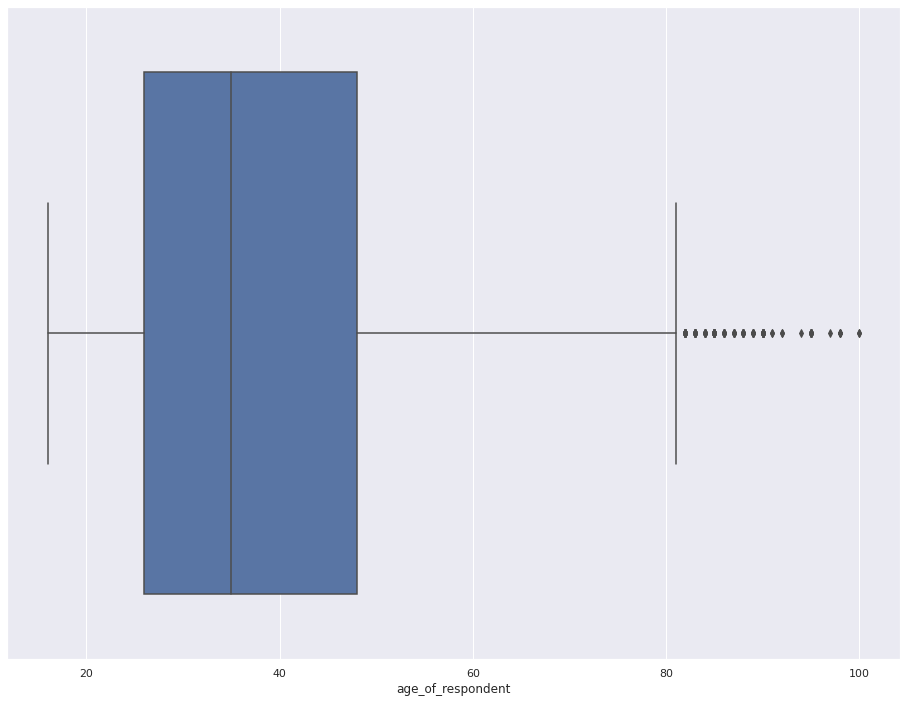

In [24]:
sns.boxplot(data=features, x=features['age_of_respondent']);

In [26]:
features.select_dtypes('object').columns

Index(['country', 'location_type', 'cellphone_access', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [27]:
## MUDANÇA 09/06 - LABELS DOS CRIA
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21]

cria1 = features.household_size.quantile(0.25)  # 2
cria2 = features.household_size.quantile(0.50)  # 3
cria3 = features.household_size.quantile(0.75)  # 5

def crias(coluna):
    if coluna <= cria1:
        return "Single Family"
    elif cria1 < coluna <= cria2:
        return "Nuclear Family"
    elif cria2 < coluna <= cria3:
        return "Extended Family"
    else:
        return "Huge Family"

features['household_size'] = features['household_size'].map(crias) #ref: https://family.lovetoknow.com/about-family-values/types-family-structures

In [28]:
# np.percentile(features.age_of_respondent, 100)
age1 = features.age_of_respondent.quantile(0.25)
age2 = features.age_of_respondent.quantile(0.50)
age3 = features.age_of_respondent.quantile(0.75)
age1, age2, age3

## MUDANÇA 02/06 - AGE LABELS ## great insight from Team PredictThis
def idade(coluna):
    if coluna <= age1:
        return "Jovem"
    elif age1 < coluna <= age2:
        return "Adulto"
    elif age2 < coluna <= age3:
        return "Velho"
    else:
        return "Mais Velho"

features['age_of_respondent'] = features['age_of_respondent'].map(idade)

In [29]:
features.select_dtypes('object').columns

Index(['country', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent', 'relationship_with_head',
       'marital_status', 'education_level', 'job_type'],
      dtype='object')

# 3.0 Pipelining Data

In [38]:
X = features #already dropped 'bank_account'
aux1['bank_account'] = aux1['bank_account'].replace(['Yes', 'No'], [1, 0])
y = aux1['bank_account'] #  'target'

In [39]:
obj_cols = list(X.select_dtypes('object').columns)

In [40]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), obj_cols)], remainder=StandardScaler())

In [41]:
%%time
# X = onehot[features_onehot] #  features
# aux1['bank_account'] = aux1['bank_account'].replace(['Yes', 'No'], [1, 0])
# y = aux1['bank_account'] #  'target'


params = {
    'xg__n_estimators': [1000, 1250],
    'xg__learning_rate': [0.01],
    'xg__max_depth': [3, 4],
    'xg__subsample': [0.5],
    'xg__colsample_bytree': [1],
    'xg__min_child_weight': [3, 8, 15] 
        }

pipexgb = Pipeline([
                    ('ct', ct),
                    ('xg', XGBClassifier(random_state=42))
                    ])


gs = GridSearchCV(pipexgb, params, cv=5, refit=True, scoring='f1_micro', verbose=True)
gs.fit(X, y)

print("best parameters: ",gs.best_params_)
print("best score: ", gs.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters:  {'xg__colsample_bytree': 1, 'xg__learning_rate': 0.01, 'xg__max_depth': 4, 'xg__min_child_weight': 3, 'xg__n_estimators': 1250, 'xg__subsample': 0.5}
best score:  0.8868388090467807
CPU times: user 28min 21s, sys: 6.23 s, total: 28min 27s
Wall time: 7min 14s


In [42]:
df_test = pd.read_csv('../input/inclusao-financeira-na-africa/test.csv')

In [43]:
df_test['household_size']= df_test['household_size'].map(crias)
df_test['age_of_respondent'] = df_test['age_of_respondent'].map(idade)

In [44]:
pred = gs.predict(df_test.drop(columns=['year', 'uniqueid', 'uid']))

In [45]:
pred_labels = pd.Series(pred).apply(lambda x: 'No' if x == 0 else 'Yes')
df_final = pd.concat([df_test['uid'], pred_labels], axis=1)
df_final.columns = ['uid', 'bank_account']
df_final.to_csv('submission.csv', index=False)